# Traveling Guinea Problem

## Problem Definition

Originally the problem was formulated as, a traveling salesperson needs to visit N cities. We'll formulate it as, a traveling guinea pig needs to visit N food bowls
* Can travel in a straight line between any pair of bowls
* We are given the coordinates of the bowls
* Must start and end at the same bowl
* Must visit each bowl at least once

Devise the shortest journey (in terms of total distance travelled).

This is a famous NP-hard problem (https://en.wikipedia.org/wiki/NP-hardness). We will make some simplifications:
* Flat 2-dimensional space
* Bowl locations are chosen at random within a square of unit length on each side

## Concept for our solution

We'll find the global minimum of *total distance of the route*, using simulated annealing
* Number the bowls in the order in which the guinea visits them
* Consider each bowl to be a single point (i.e. has no spatial extent)
* Denote the position of bowl i by 2D vector $r_i = (x_i, y_i)$ with $r_N = r_0$
* Start with random route
* Try swapping the order of 2 randomly-chosen bowls in the route, use Metropolis to determine whether to keep the swap
   * 'Temperature' T follows exponential cooling schedule, with time constant $\tau$ and initial temperature $T_0$
* Stop when temperature reaches $T_f$

![Newman's fig. 10.6](fig10-6.png)

### Exercise 1

Define a function to calculate the total distance travelled by the guinea over the entire journey. This is the quantity we'll be minimizing.

In [445]:
import numpy as np
import matplotlib.pyplot as plt
import random


def distance(r):
    """Define distance assuming we get an array of bowl positions (2d vectors)"""
    distance_array = []  # distance of each point
    for i in range(len(r) - 1):
        distance_array.append(
            np.sqrt((r[i + 1][0] - r[i][0]) ** 2 + (r[i + 1][1] - r[i][1]) ** 2)
        )

    distance_array = np.array(distance_array)
    return distance_array.sum()


# Test

r = np.array([[1, 1], [1, 0], [0, 0], [1, 1]])
print(distance(r))

3.414213562373095


### Exercise 2

Write a function that randomly sets the bowl locations. It should take N as an argument, and return a 2D array (or, if you prefer, an array of 2-element vectors) containing the x and y positions of the bowls.

In [446]:
def set_random_bowls(N):
    """Sets N bowl locations randomly, bowl locations in a unit length either side.
    Returns an array with position of each bowl. Makes the last bowl the first bowl"""
    r = np.empty([N + 1, 2], float)
    for i in range(N):
        r[i, 0] = np.random.random()
        r[i, 1] = np.random.random()
    r[N] = r[0]
    return r

### Exercise 3

Write a function that creates a graphical representation of the bowls' positions. It should also draw a line between each bowl i and i+1 (ideally we would have an arrow on each line, but don't bother trying to implement this.)

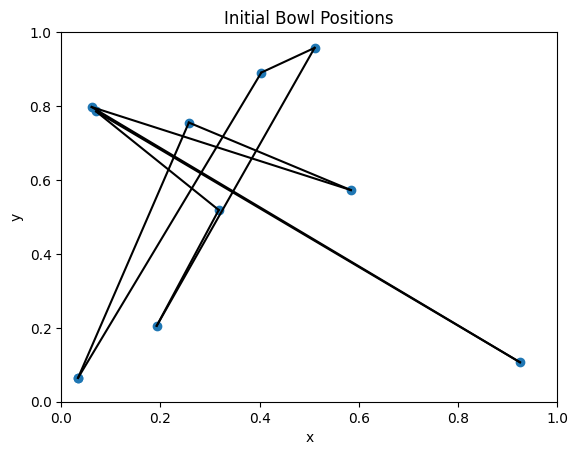

In [447]:
# Unpack array of [[x1, y1], [x2, y2]] to x, y
np.random.seed(523)
N = 10
bowl_pos = set_random_bowls(N)


def draw_bowls(bowl_pos, title="Initial Bowl Positions"):
    x, y = bowl_pos[:, 0], bowl_pos[:, 1]

    for i in range(len(x)):
        plt.plot(x[i : i + 2], y[i : i + 2], color="k")
    plt.scatter(x, y)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"{title}")


title2 = "Final Bowl Position"
draw_bowls(bowl_pos)

## Implementing Markov Chain with Metropolis Algorithm

### Exercise 4

Write a function that decides whether or not to perform a swap. It should take as input: the old distance (before the swap), the new distance (after the swap), and the 'temperature'. It should return something representing reject or accept.

In [448]:
def decide(old_distance, new_distance, T):
    """If the change in distance is negative. Always accept (>1)."""
    delta_distance = new_distance - old_distance

    if np.random.random() < np.exp(-delta_distance / T):
        return True
    return False


decide(2, 5, 0.1)

False

Also write a function that chooses, at random, two different bowl numbers (excluding 0 and excluding N). It should take as input how many bowls there are, and return the two chosen numbers.

In [449]:
def choose_two_bowls(N):
    """Choose two bowls from N bowls, exclude 0 and N"""
    i = random.randrange(1, N - 1)
    j = random.randrange(1, N - 1)
    while i == j:
        j = random.randrange(1, N - 1)
    return i, j


choose_two_bowls(10)

(4, 5)

Then write a function that tries a swap of two randomly-chosen bowls, and keeps or rejects the swap according to the Metropolis algorithm. It should take the array of bowl positions, and T, as input. It should return the new array of bowl positions (which may or may not be different from the input array).

[[0 0]
 [1 0]
 [1 1]
 [0 1]
 [0 0]]


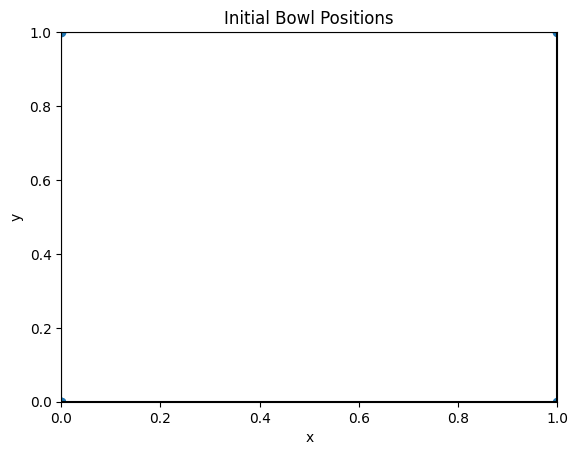

In [450]:
def swap(bowl_pos, T):
    bowl1, bowl2 = choose_two_bowls(len(bowl_pos))
    # print(bowl1)

    # create a new array and swap the positions
    try_bowl_pos = bowl_pos.copy()
    # print(try_bowl_pos)
    try_bowl_pos[bowl1, 1], try_bowl_pos[bowl2, 1] = (
        try_bowl_pos[bowl2, 1],
        try_bowl_pos[bowl1, 1],
    )
    try_bowl_pos[bowl1, 0], try_bowl_pos[bowl2, 0] = (
        try_bowl_pos[bowl2, 0],
        try_bowl_pos[bowl1, 0],
    )

    orig_distance = distance(bowl_pos)
    try_distance = distance(try_bowl_pos)
    switch = decide(orig_distance, try_distance, T)

    if switch:
        # pass
        return try_bowl_pos
    return bowl_pos


bowl_pos = np.array([[0, 0], [1, 1], [1, 0], [0, 1], [0, 0]])
T = 100000000
for i in range(1000):
    T /= 2
    if T < 0.01:
        T = 0.01
    new = swap(bowl_pos, T)
print(new)

draw_bowls(new)

### Exercise 5

Write code that: 
* calls your function to initialize the bowl locations
* calls your function to draw a map of the bowl locations
* prints out the total distance for the initial path
* performs the simulated annealing to minimize the distance along the path
* draws a map of the bowl locations and total distance for the solution

You should have $N,~\tau,~T_0,~T_f$ as parameters; for now, set them to the following values:

Total Distance Initially: 10.334685492775861


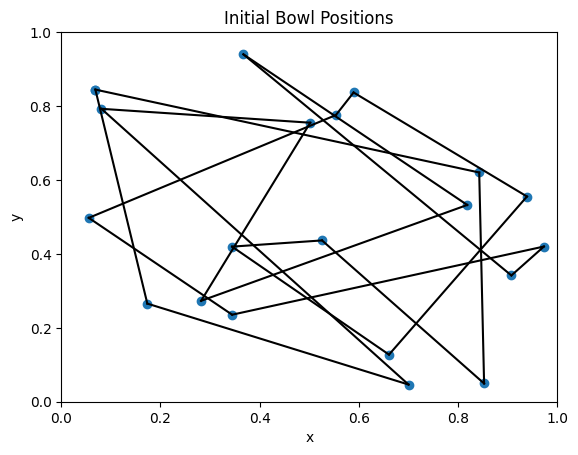

In [451]:
N = 20
tau = 1e4
T0 = 10.0
Tf = 1e-3

bowl_pos = set_random_bowls(N)
draw_bowls(bowl_pos)
print(f"Total Distance Initially: {distance(bowl_pos)}")

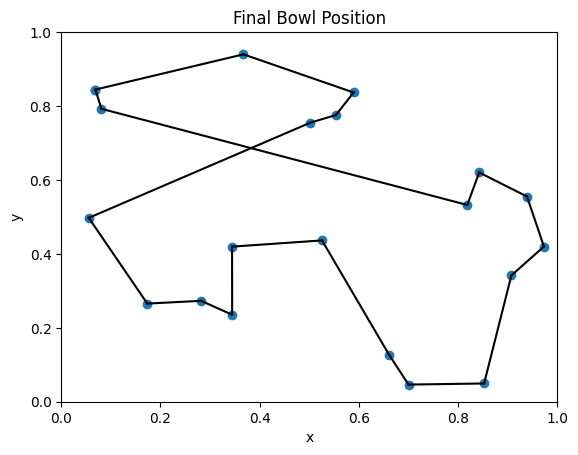

In [452]:
# Simulated Annealing
def getTemp(T0, tau, t):
    return T0 * np.exp(-t / tau)


T = T0
time = 0

final_bowl_pos = bowl_pos.copy()

while T > Tf:
    time += 1
    T = getTemp(T0, tau, time)
    # T = T / 2
    final_bowl_pos = swap(final_bowl_pos, T)

draw_bowls(final_bowl_pos, title=title2)

### Exercise 6

Now modify your code to produce, along the way, two 'diagnostic' plots to get some more insight into what the algorithm is doing:
* distance vs t
* T vs t

This means your code has to keep track of distance and T at each step. 

Also make your code time how long the simulated annealing algorithm takes (not including the initialization of the bowls, and not including any plotting).

Time Taken: 28.174716472625732 s


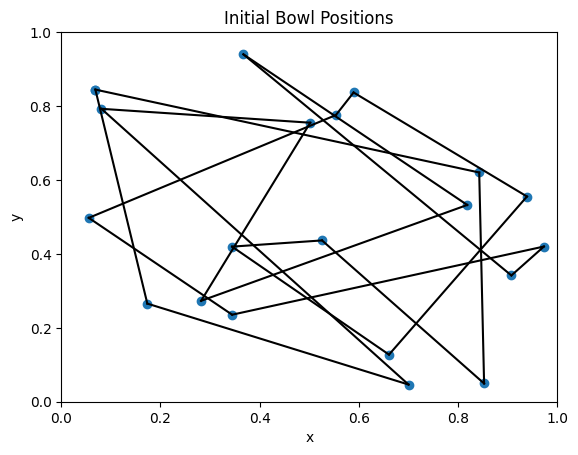

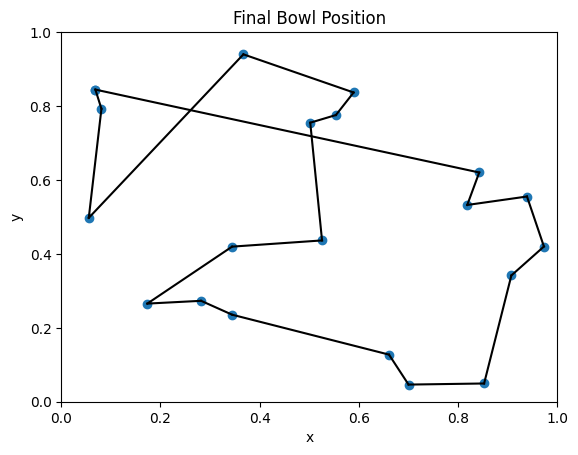

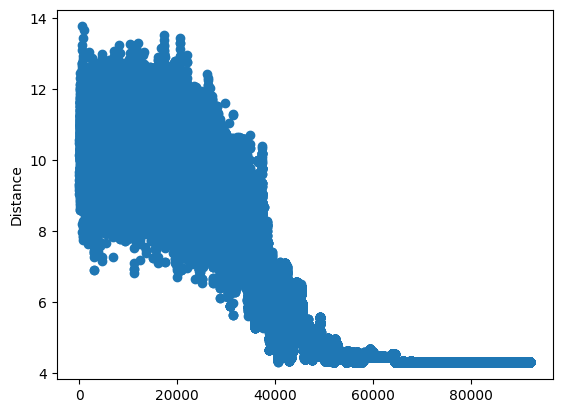

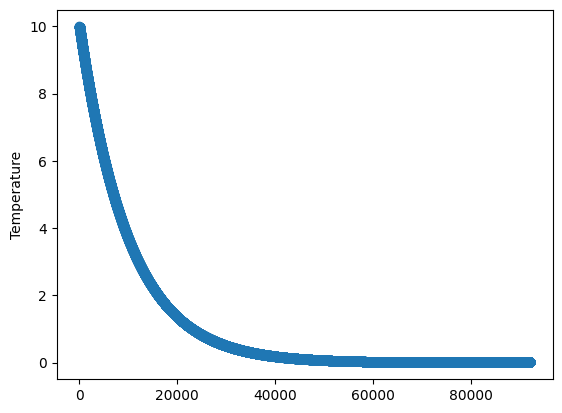

In [453]:
import time


def annealing(T0, Tf, tau, bowl_pos):
    T = T0
    t = 0

    final_bowl_pos = bowl_pos.copy()
    time_array = []
    distance_array = []
    temp_array = []

    start = time.time()
    while T > Tf:
        t += 1
        T = getTemp(T0, tau, t)
        # T = T / 2
        final_bowl_pos = swap(final_bowl_pos, T)

        time_array.append(t)
        distance_array.append(distance(final_bowl_pos))
        temp_array.append(T)

    print(f"Time Taken: {time.time() - start} s")

    draw_bowls(bowl_pos)
    plt.figure()
    draw_bowls(final_bowl_pos, title2)
    plt.figure()
    plt.scatter(time_array, distance_array)
    plt.ylabel("Distance")
    plt.figure()
    plt.scatter(time_array, temp_array)
    plt.ylabel("Temperature")


annealing(T0, Tf, tau, bowl_pos)

Takes 31s

### Exercise 7

Try your code from the previous exercise with $N=40$, then $N=60$. As you increase N, do you notice the computation time going up? What about the number of steps required to reach a solution?

Time Taken: 54.347079038619995 s


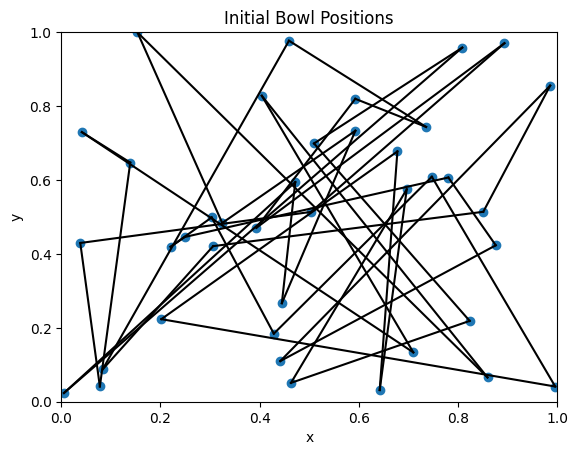

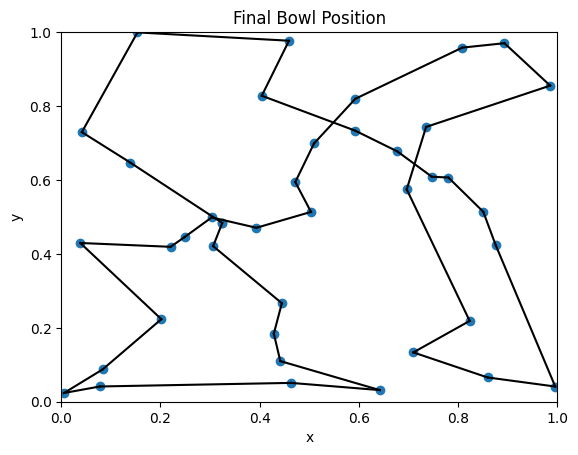

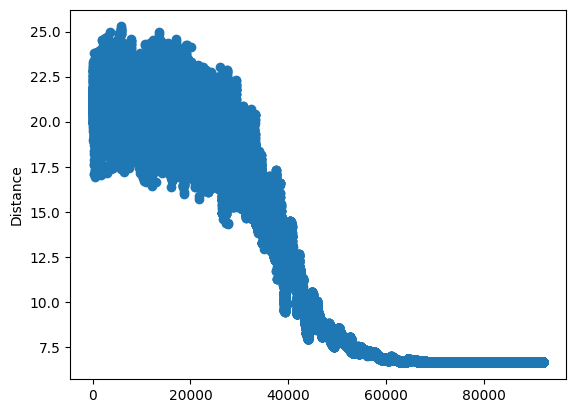

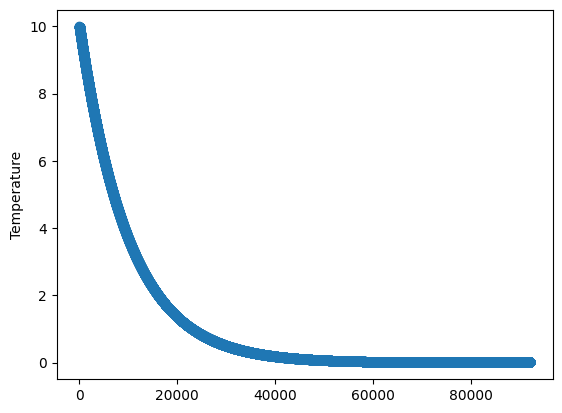

In [454]:
# N = 40
N = 40
bowl_pos = set_random_bowls(N)
annealing(T0, Tf, tau, bowl_pos)

Time Taken: 77.58253312110901 s


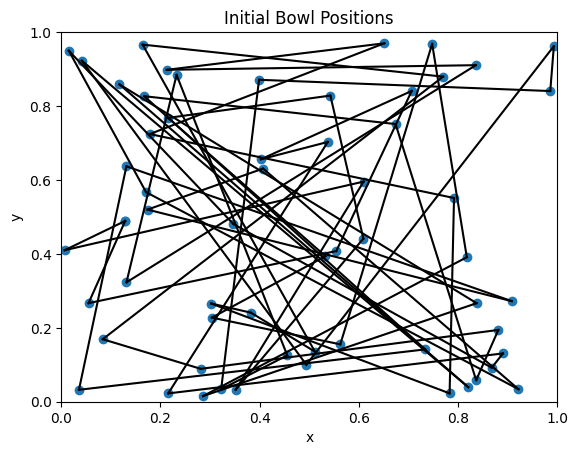

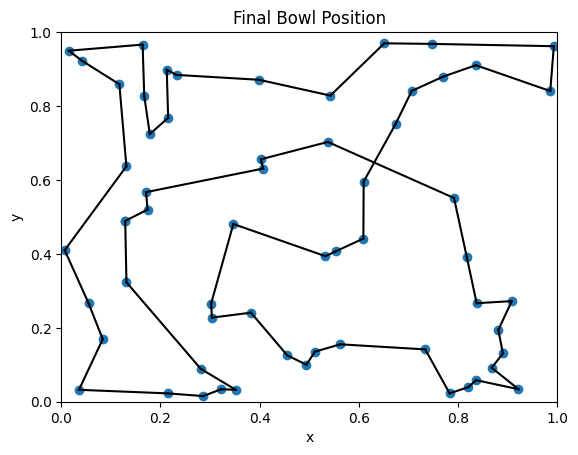

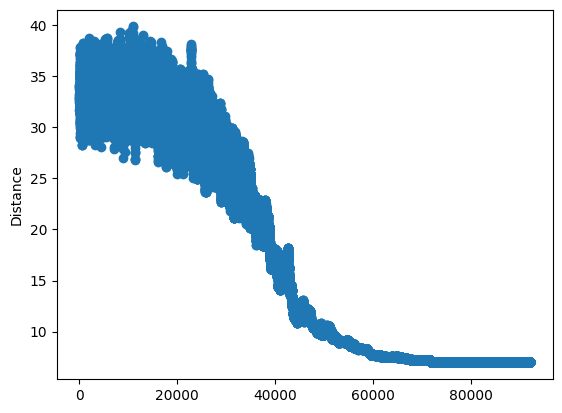

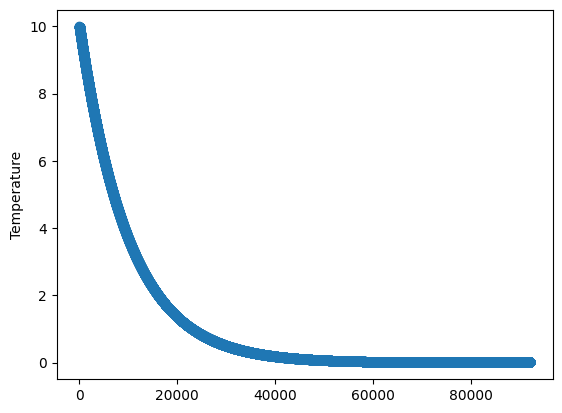

In [455]:
# N = 60
N = 60
bowl_pos = set_random_bowls(N)
annealing(T0, Tf, tau, bowl_pos)

### Exercise 8

With $N=60$, now try a few different values of $\tau: ~100,~1000,~10000$, with the same random seed each time. Does the solution itself change? What about the execution time? Can you see the trade-off between computational speed and possibility of getting stuck in local minimum?

Time Taken: 0.7776656150817871 s


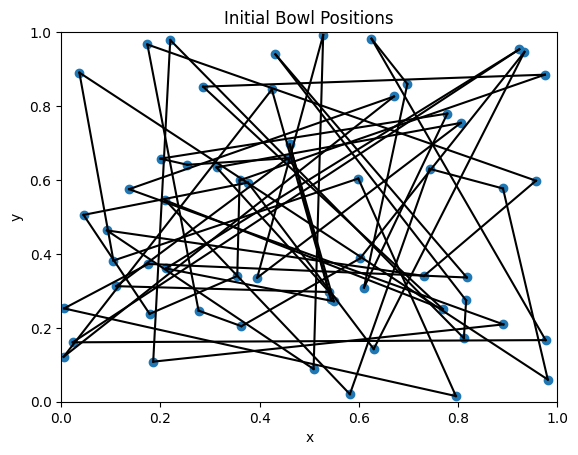

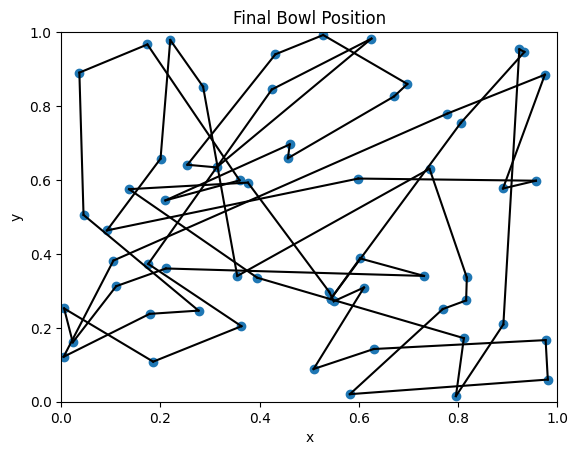

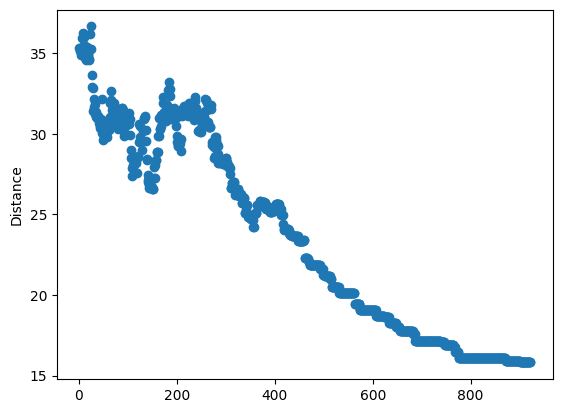

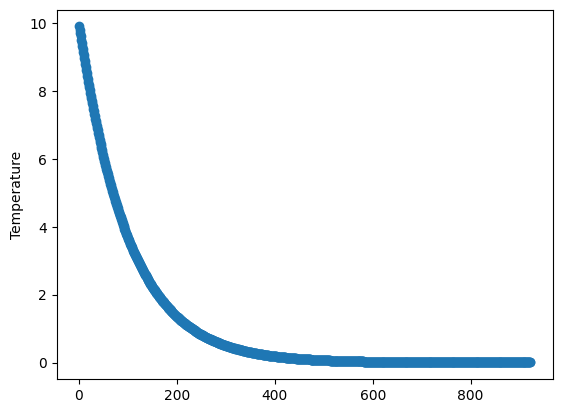

In [456]:
np.random.seed(100)
random.seed(100)

# tau = 100
tau = 100
bowl_pos = set_random_bowls(N)
annealing(T0, Tf, tau, bowl_pos)

Time Taken: 7.920569181442261 s


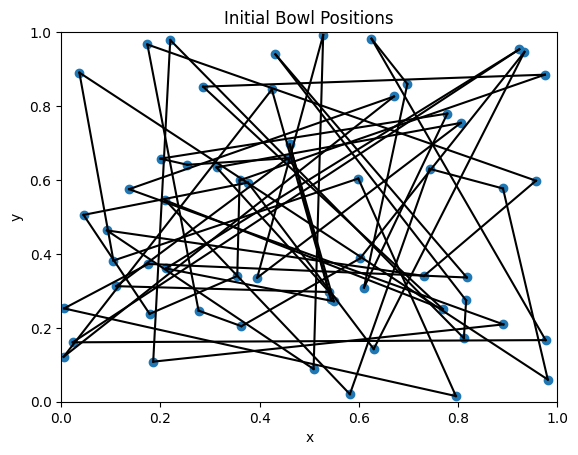

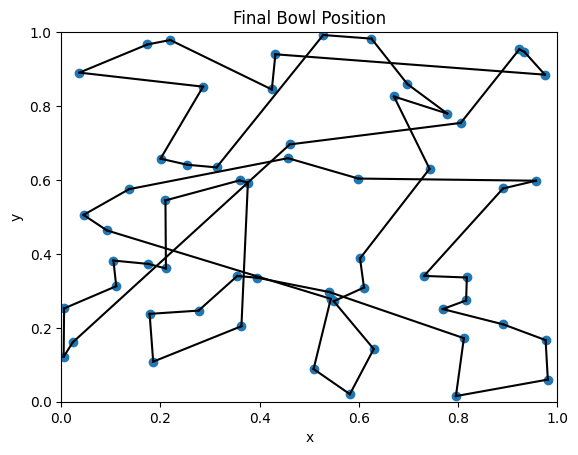

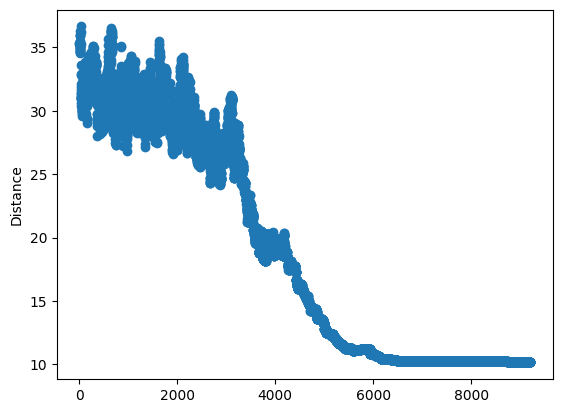

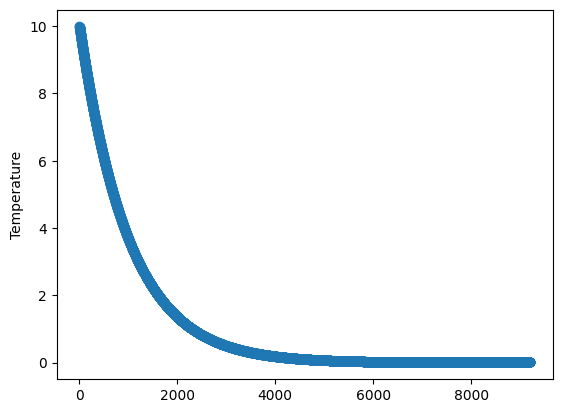

In [457]:
np.random.seed(100)
random.seed(100)

# tau = 1000
tau = 1000
bowl_pos = set_random_bowls(N)
annealing(T0, Tf, tau, bowl_pos)

Time Taken: 81.79955196380615 s


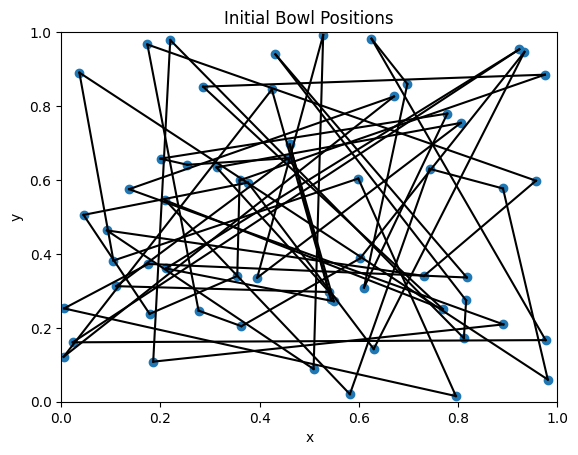

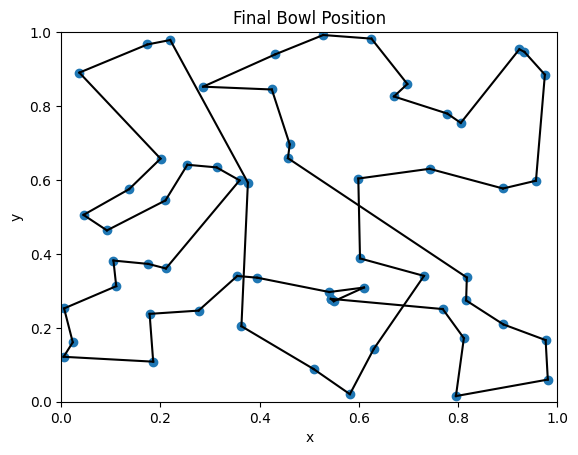

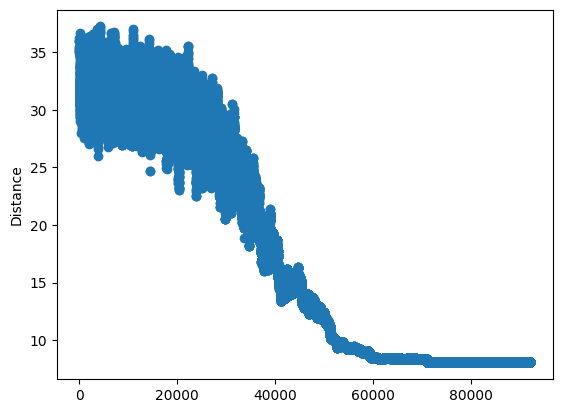

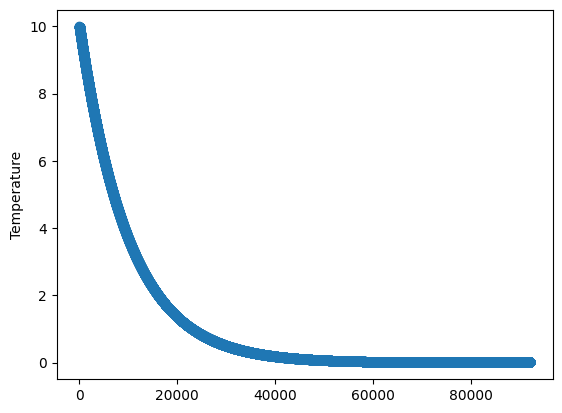

In [458]:
np.random.seed(100)
random.seed(100)

# tau = 10000
tau = 10000
bowl_pos = set_random_bowls(N)
annealing(T0, Tf, tau, bowl_pos)